X3,threshold optimizer(demographic_parity): Accuracy: 0.639757140408356

Statistical Parity Difference: 0.059784578737507116

Statistical Parity ratio: 0.6731776362349611

Equalized Odds Difference: 0.1180592991913747

Equalized Odds Ratio: 0.3298199078598352

In [2]:
# Installing the fairlearn package
!pip install fairlearn
!pip install xlrd

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover
from sklearn.pipeline import Pipeline
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from sklearn.inspection import permutation_importance

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


#reading file
file_path = r"C:\Users\User\Downloads\default_of_credit_card_clients.xls"

# Read Excel file into a DataFrame
df = pd.read_excel(file_path)

X=df.drop(columns=['Unnamed: 0'])

# continue with preperation
X=X.drop(columns=['Y'])

#get list of feature names
feature_names= X.iloc[0].values
feature_names = np.array(feature_names)
X=X.drop(index=0)

y=df['Y']
y=y.drop(index=0)

y=pd.to_numeric(y)
y.head()
X = X[X['X3'] != 0]
X['X3'] = X['X3'].replace({5: 4, 6: 4})
X = X[X['X4'] != 0]
X['X4'] = X['X4'].replace({4:3,5: 3, 6: 3})
y = y[X.index]  # Update y to match the filtered rows in X
for column in X:
    X[column] = pd.to_numeric(X[column])
    X[column].head()


print(X)
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#
#sensitive_test = X_test['X2']



y.head()

           X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...     X14    X15    X16  \
1       20000   2   2   1  24   2   2  -1  -1   -2  ...     689      0      0   
2      120000   2   2   2  26  -1   2   0   0    0  ...    2682   3272   3455   
3       90000   2   2   2  34   0   0   0   0    0  ...   13559  14331  14948   
4       50000   2   2   1  37   0   0   0   0    0  ...   49291  28314  28959   
5       50000   1   2   1  57  -1   0  -1   0    0  ...   35835  20940  19146   
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...     ...    ...    ...   
29996  220000   1   3   1  39   0   0   0   0    0  ...  208365  88004  31237   
29997  150000   1   3   2  43  -1  -1  -1  -1    0  ...    3502   8979   5190   
29998   30000   1   2   2  37   4   3   2  -1    0  ...    2758  20878  20582   
29999   80000   1   3   1  41   1  -1   0   0    0  ...   76304  52774  11855   
30000   50000   1   2   1  46   0   0   0   0    0  ...   49764  36535  32428   

         X17    X18    X19 

1    1
2    1
3    0
4    0
5    0
Name: Y, dtype: int64

In [6]:
model=RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=150)


C:\Users\User\anaconda3\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:292: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


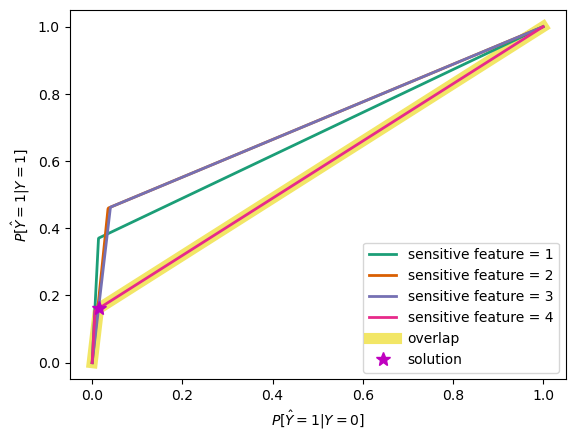

In [7]:
#SAME AS X3 BUT WITH DIFFRENT CONSTRAINT
sensitive_train = X_train['X3']
sensitive_test = X_test['X3']
threshold_optimizer = ThresholdOptimizer(
    estimator=model,
    objective="balanced_accuracy_score",
    constraints="equalized_odds",
)
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_train)

plot_threshold_optimizer(threshold_optimizer)

In [8]:
y_pred = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test)

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5534369532101516


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='X3'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>],
       [<AxesSubplot:xlabel='X3'>, <AxesSubplot:xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>]], dtype=object)

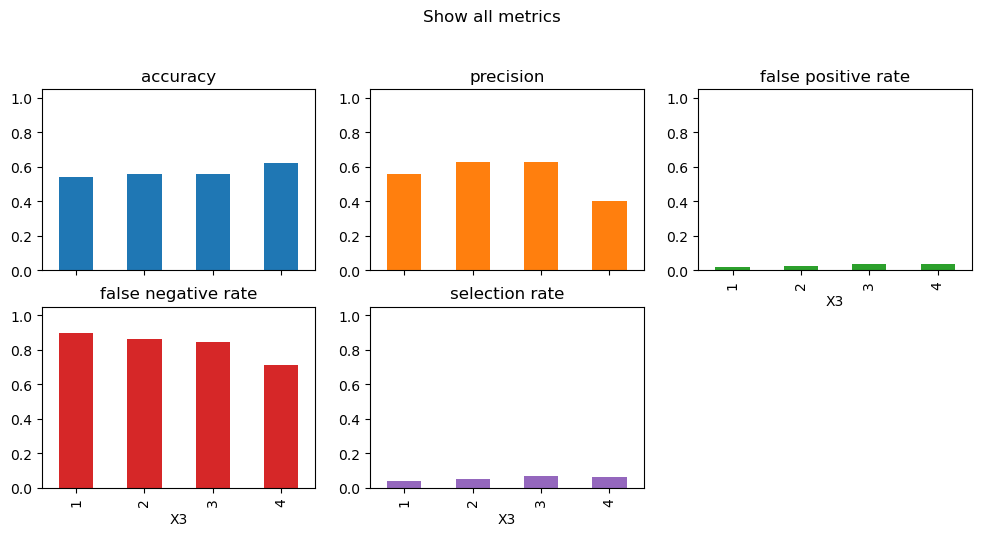

In [10]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [11]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.03212503069302108
Statistical Parity ratio: 0.534928401813341
Equalized Odds Difference: 0.18409765753876606
Equalized Odds Ratio: 0.3556581986143187


C:\Users\User\anaconda3\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:292: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


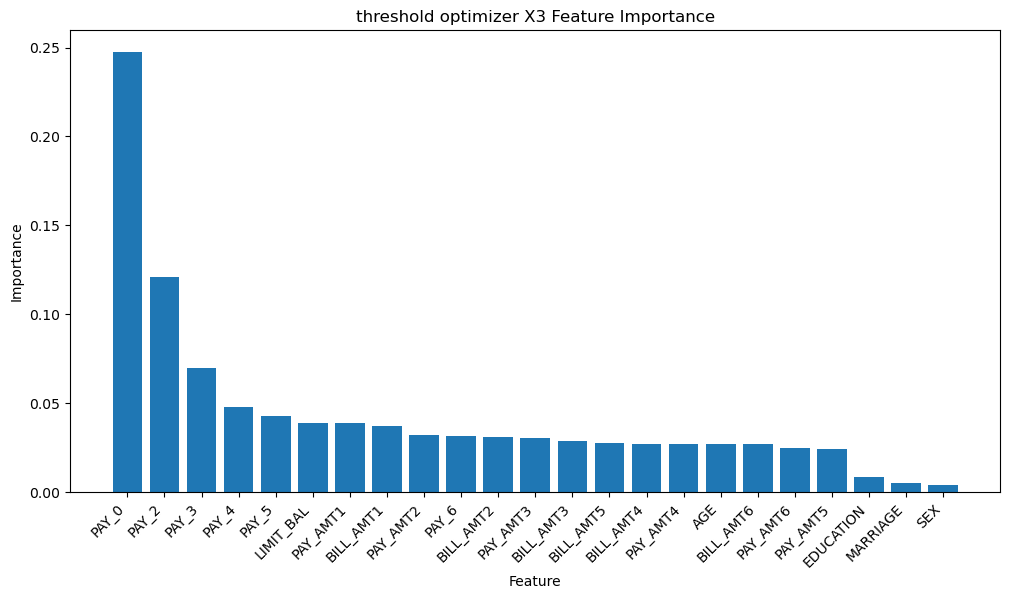

In [12]:
import matplotlib.pyplot as plt
from fairlearn.postprocessing import ThresholdOptimizer

# Fit the model
model.fit(X_train, y_train)

# Fit the threshold optimizer
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_train)

# Get feature importances after applying the threshold optimizer
optimized_feature_importances = threshold_optimizer.estimator_.feature_importances_

# Create a DataFrame for feature names and their importance scores
optimized_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': optimized_feature_importances})

# Sort the DataFrame by importance in descending order
optimized_feature_importance_df = optimized_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the bar chart for optimized feature importance
plt.figure(figsize=(12, 6))
plt.bar(optimized_feature_importance_df['Feature'], optimized_feature_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('threshold optimizer X3 Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()


X3,exponentiated gradient:Accuracy: 0.6450868556976108

Statistical Parity Difference: 0.03208833363572744

Statistical Parity ratio: 0.75249900039984

Equalized Odds Difference: 0.34872979214780603

Equalized Odds Ratio: 0.0

In [13]:
sensitive_train = X_train['X3']
sensitive_test = X_test['X3']
exponentiated_gradient = ExponentiatedGradient(
    estimator=model,
    constraints=DemographicParity(),
    sample_weight_name="sample_weight"
)
exponentiated_gradient.fit(X_train, y_train, sensitive_features=sensitive_train)
y_pred = exponentiated_gradient.predict(X_test)
# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6396571213262999


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='X3'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>],
       [<AxesSubplot:xlabel='X3'>, <AxesSubplot:xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>]], dtype=object)

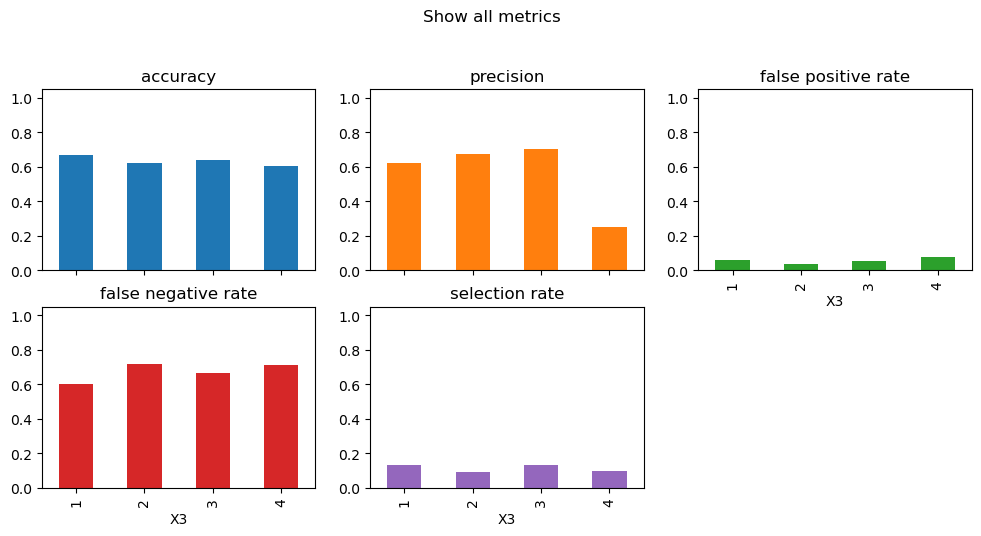

In [14]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [15]:
# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.04083457615748104
Statistical Parity ratio: 0.6925973106864827
Equalized Odds Difference: 0.11587815509828236
Equalized Odds Ratio: 0.4820780399274047


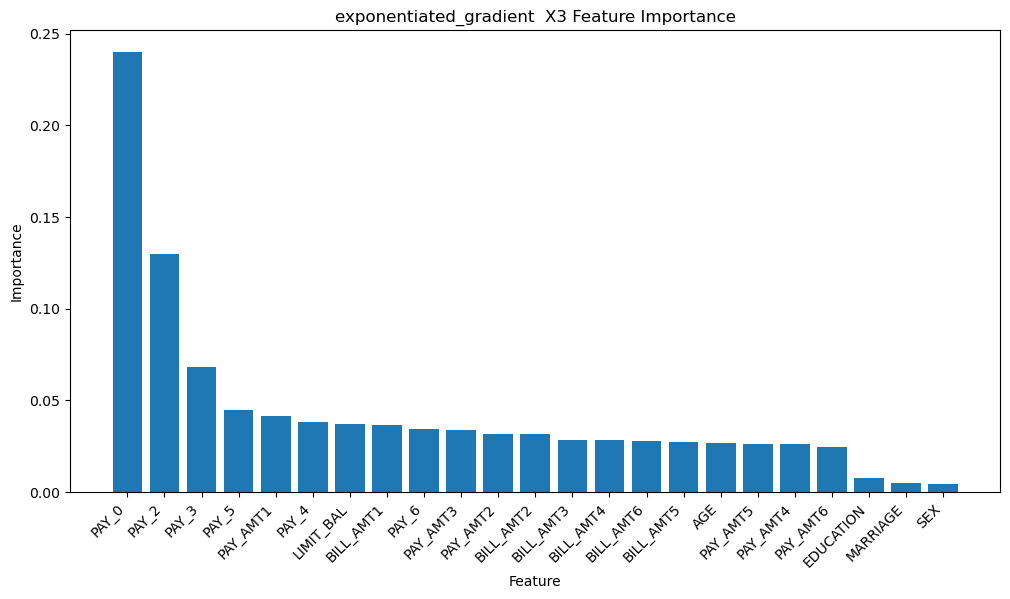

In [16]:
import matplotlib.pyplot as plt
from fairlearn.postprocessing import ThresholdOptimizer

model.fit(X_train, y_train)

# Get the underlying model from the exponentiated gradient estimator
optimized_feature_importances =  exponentiated_gradient.estimator.feature_importances_

# Create a DataFrame for feature names and their importance scores
optimized_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': optimized_feature_importances})

# Sort the DataFrame by importance in descending order
optimized_feature_importance_df = optimized_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the bar chart for optimized feature importance
plt.figure(figsize=(12, 6))
plt.bar(optimized_feature_importance_df['Feature'], optimized_feature_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('exponentiated_gradient  X3 Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()